In [ ]:
# network.py: script for downloading data from spotify

import os
import time
from datetime import date

import pandas as pd
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials
from spotipy.exceptions import SpotifyException


# ---------------------------------------------------------------------------
# Configuration
# ---------------------------------------------------------------------------

# Input CSV with two columns: "Artist" and "Listeners"
CSV_IN        = "October_listeners1.csv"
ARTIST_COL    = "Artist"
LISTENERS_COL = "Listeners"

# How many top artists (by listeners) to keep from the input file
TOP_N         = 1410

# Spotify market to use when fetching albums / tracks
MARKET        = "US"

# Output CSV where collaboration edges will be written
OUT_CSV       = "collab_edges_2025_october.csv"

# Time window for “recent” releases we care about
SINCE_D   = date(2025, 10, 1)   # inclusive lower bound
TOWARDS_D = date(2025, 11, 1)   # exclusive upper bound

# Initialize Spotify client with client credentials from environment
sp = spotipy.Spotify(
    auth_manager=SpotifyClientCredentials(
        client_id=os.getenv("SPOTIPY_CLIENT_ID"),
        client_secret=os.getenv("SPOTIPY_CLIENT_SECRET"),
    ),
    requests_timeout=30,
)


# ---------------------------------------------------------------------------
# Helper: robust wrapper around Spotipy API calls
# ---------------------------------------------------------------------------

def safe_sp_call(func, *args, **kwargs):
    """
    Call a Spotipy function with basic retry & rate-limit handling.

    - Retries up to 5 times on generic exceptions, backing off slightly each time.
    - If a 429 Rate Limit error occurs:
        * Read the `Retry-After` header.
        * If the wait is > 60 seconds, skip this call and return None.
        * Otherwise sleep for (Retry-After + 1) seconds and retry.
    - On other HTTP errors, re-raise immediately.

    Parameters
    ----------
    func : callable
        Spotipy client method (e.g., sp.search, sp.artist_albums, ...).
    *args, **kwargs :
        Positional and keyword arguments passed through to `func`.

    Returns
    -------
    Any or None
        Whatever the Spotipy method would normally return, or None if we give up.
    """
    for attempt in range(5):
        try:
            return func(*args, **kwargs)
        except SpotifyException as e:
            # Explicit handling for rate limiting
            if e.http_status == 429:
                ra = int(e.headers.get("Retry-After", "5"))
                if ra > 60:
                    print(f"[rate-limit] Retry-After={ra}s is too long, skipping call")
                    return None
                print(f"[rate-limit] hit; waiting {ra}s before retrying")
                time.sleep(ra + 1)
            else:
                # Other HTTP errors: fail fast so we notice
                raise
        except Exception as e:
            # Generic network / transient errors: retry a few times
            print(f"[warn] {e}, attempt {attempt+1}/5")
            time.sleep(1 + attempt)

    # All retries exhausted
    return None


# ---------------------------------------------------------------------------
# Step 1: Load & clean the list of top artists
# ---------------------------------------------------------------------------

def load_top_artists(path: str) -> list[str]:
    """
    Load the top artists from a CSV and return a clean list of artist names.

    The CSV is expected to contain at least two columns:
      - ARTIST_COL (e.g., 'Artist')
      - LISTENERS_COL (e.g., 'Listeners')

    Cleaning steps:
      1. Strip whitespace from the artist column.
      2. Remove commas and spaces from the listeners column, then convert to float.
      3. Drop rows with missing artist or listeners.
      4. Sort by listeners (descending).
      5. Keep the top TOP_N artists.
      6. Drop duplicate artist names, keeping the first occurrence.

    Parameters
    ----------
    path : str
        Path to the input CSV.

    Returns
    -------
    list[str]
        List of cleaned artist names, sorted by listener count (highest first).
    """
    df = pd.read_csv(path)

    # Clean artist names
    df[ARTIST_COL] = df[ARTIST_COL].astype(str).str.strip()

    # Clean listeners: remove commas and spaces then parse as float
    df[LISTENERS_COL] = (
        df[LISTENERS_COL].astype(str)
        .str.replace(",", "", regex=False)
        .str.replace(" ", "", regex=False)
    ).astype(float)

    # Remove rows that are missing either artist or listeners
    df = df.dropna(subset=[ARTIST_COL, LISTENERS_COL])

    # Sort by listeners and keep only the top N
    df = df.sort_values(LISTENERS_COL, ascending=False).head(TOP_N)

    # Ensure each artist appears at most once
    df = df.drop_duplicates(subset=[ARTIST_COL], keep="first")

    return df[ARTIST_COL].tolist()


# ---------------------------------------------------------------------------
# Step 2: Resolve artist names to Spotify artist IDs
# ---------------------------------------------------------------------------

def resolve_artist_ids(names: list[str]) -> dict[str, str]:
    """
    Resolve a list of artist name strings to Spotify artist IDs.

    For each name, we run a Spotify search query constrained to the artist field
    and take the first search result, if any.

    Parameters
    ----------
    names : list[str]
        Artist names to resolve.

    Returns
    -------
    dict[str, str]
        Mapping from original artist name -> Spotify artist ID.
        Artists that cannot be resolved are skipped.
    """
    name2id: dict[str, str] = {}

    for name in names:
        res = safe_sp_call(
            sp.search,
            q=f'artist:"{name}"',
            type="artist",
            limit=1
        )
        if not res:
            print(f"[resolve] skip {name} (no search result / call failed)")
            continue

        items = res["artists"]["items"]
        if items:
            aid = items[0]["id"]
            name2id[name] = aid
            print(f"[resolve] {name} -> {aid}")
        else:
            print(f"[resolve] skip {name} (empty search items)")

        # Short pause to be kind to the API
        time.sleep(0.25)

    return name2id


# ---------------------------------------------------------------------------
# Utility: Normalize Spotify release_date strings into datetime.date objects
# ---------------------------------------------------------------------------

def norm_date(rd: str | None) -> date | None:
    """
    Normalize a Spotify `release_date` string into a Python `date`.

    Spotify release dates may come in three formats:
      - 'YYYY'        -> interpret as January 1st of that year
      - 'YYYY-MM'     -> interpret as the 1st of that month
      - 'YYYY-MM-DD'  -> interpret as the exact date

    If the format is not recognized or rd is falsy, return None.

    Parameters
    ----------
    rd : str or None
        Release date string from the Spotify API.

    Returns
    -------
    datetime.date or None
        Normalized date object, or None if parsing fails.
    """
    if not rd:
        return None

    if len(rd) == 4:
        # Year only
        return date(int(rd), 1, 1)

    if len(rd) == 7:
        # Year and month
        y, m = rd.split("-")
        return date(int(y), int(m), 1)

    if len(rd) == 10:
        # Full date
        y, m, d = rd.split("-")
        return date(int(y), int(m), int(d))

    # Unknown format
    return None


# ---------------------------------------------------------------------------
# Step 3: Fetch recent albums for a given artist
# ---------------------------------------------------------------------------

def fetch_recent_albums_for_artist(
    artist_id: str,
    since: date,
    towards: date
) -> list[dict]:
    """
    Fetch albums for a single artist within a date window.

    This uses `sp.artist_albums` and iterates with pagination.

    Only albums whose release_date (normalized to a date) lies in the
    interval [since, towards) are kept.

    The loop stops when we encounter items older than `since`, under the
    assumption that the results are returned in reverse-chronological order.

    Parameters
    ----------
    artist_id : str
        Spotify artist ID.
    since : datetime.date
        Inclusive lower bound on release date.
    towards : datetime.date
        Exclusive upper bound on release date.

    Returns
    -------
    list[dict]
        List of album objects from the Spotify API, filtered by date.
    """
    albums: list[dict] = []
    offset, limit = 0, 50
    seen = 0

    while True:
        resp = safe_sp_call(
            sp.artist_albums,
            artist_id,
            include_groups="album,single,appears_on",
            country=MARKET,
            limit=limit,
            offset=offset,
        )
        if not resp:
            break

        items = resp.get("items", [])
        if not items:
            break

        stop_here = False

        for alb in items:
            rd = norm_date(alb.get("release_date"))

            if rd:
                # Older than lower bound -> we can stop paginating this artist
                if rd < since:
                    stop_here = True
                    break
                # On or after upper bound -> skip
                if rd >= towards:
                    continue

            # Album lies in the desired date range
            albums.append(alb)
            seen += 1

        if stop_here:
            break

        offset += limit

        # Safety cap: do not fetch an excessive number of albums per artist
        if seen >= 200:
            break

        time.sleep(0.4)

    return albums


# ---------------------------------------------------------------------------
# Step 4: Fetch all tracks for a given album
# ---------------------------------------------------------------------------

def album_tracks_all(album_id: str) -> list[dict]:
    """
    Fetch **all** tracks for the given album, handling pagination.

    Parameters
    ----------
    album_id : str
        Spotify album ID.

    Returns
    -------
    list[dict]
        List of track objects from the Spotify API.
    """
    tracks: list[dict] = []
    offset, limit = 0, 50

    while True:
        resp = safe_sp_call(
            sp.album_tracks,
            album_id,
            limit=limit,
            offset=offset,
            market=MARKET,
        )
        if not resp:
            break

        items = resp.get("items", [])
        tracks.extend(items)

        # `next` is a full URL; if missing, there are no more pages
        if not resp.get("next"):
            break

        offset += limit
        time.sleep(0.2)

    return tracks


# ---------------------------------------------------------------------------
# Step 5: Build collaboration edges between seed artists
# ---------------------------------------------------------------------------

def collect_collab_edges(
    name2id: dict[str, str],
    since: date,
    towards: date
) -> pd.DataFrame:
    """
    Collect collaboration edges between a set of seed artists.

    For each seed artist:
      1. Fetch all recent albums within [since, towards).
      2. For each album, fetch all its tracks.
      3. For each track, extract its list of artist IDs and names.
      4. If at least one of the artists on the track is in the seed set,
         create undirected edges between every pair of artists on that track.

    Each edge corresponds to a co-appearance of two artists on a track.
    We record:
      - album_id
      - album_name
      - track_name
      - release_date
      - artist_u_id, artist_u_name
      - artist_v_id, artist_v_name

    Parameters
    ----------
    name2id : dict[str, str]
        Mapping from artist name to Spotify artist ID for seed artists.
    since : datetime.date
        Inclusive lower bound on release date.
    towards : datetime.date
        Exclusive upper bound on release date.

    Returns
    -------
    pandas.DataFrame
        DataFrame where each row is one collaboration edge.
    """
    seed_ids = set(name2id.values())
    edges: list[dict] = []
    seen_albums: set[str] = set()

    for i, (name, aid) in enumerate(name2id.items(), start=1):
        print(f"[artist {i}/{len(name2id)}] {name}")
        albums = fetch_recent_albums_for_artist(aid, since, towards)

        for alb in albums:
            rd = norm_date(alb.get("release_date"))
            if rd and (rd < since or rd >= towards):
                # Extra safety filter: ignore out-of-range albums
                continue

            alb_id = alb["id"]
            if alb_id in seen_albums:
                # Avoid processing the same album multiple times
                continue
            seen_albums.add(alb_id)

            tracks = album_tracks_all(alb_id)

            for tr in tracks:
                tr_name = tr.get("name")
                tr_artists = tr.get("artists") or []

                # Parallel lists of IDs and names
                a_ids = [a["id"] for a in tr_artists if a.get("id")]
                a_names = [a["name"] for a in tr_artists if a.get("name")]

                # Skip tracks that involve no seed artists
                if not seed_ids.intersection(a_ids):
                    continue

                # For n artists on a track, create all unordered pairs (u < v)
                n = len(a_ids)
                for u in range(n):
                    for v in range(u + 1, n):
                        edges.append(
                            {
                                "album_id": alb_id,
                                "album_name": alb.get("name"),
                                "track_name": tr_name,
                                "release_date": alb.get("release_date"),
                                "artist_u_id": a_ids[u],
                                "artist_u_name": a_names[u],
                                "artist_v_id": a_ids[v],
                                "artist_v_name": a_names[v],
                            }
                        )

        # Small pause between artists to be gentle on the API
        time.sleep(0.5)

    return pd.DataFrame(edges)


# ---------------------------------------------------------------------------
# Main script
# ---------------------------------------------------------------------------

if __name__ == "__main__":
    # 1. Load & clean top artists from the listeners CSV
    artists = load_top_artists(CSV_IN)
    print(f"[info] loaded {len(artists)} top artists from {CSV_IN}")

    # 2. Resolve each artist name to a Spotify ID
    name2id = resolve_artist_ids(artists)
    print(f"[info] resolved {len(name2id)} artists to Spotify IDs")

    # 3. Collect collaboration edges within the specified date window
    df = collect_collab_edges(name2id, SINCE_D, TOWARDS_D)

    # 4. Save to CSV
    df.to_csv(OUT_CSV, index=False)
    print(f"[done] wrote {len(df)} collaboration edges -> {OUT_CSV}")


Reading Network Files...
Main Dataset Ready: 41890 interactions.

 Identifying Core Cohort...
   Original Universe: 6709 artists
   Core Cohort (Active >= 3 months): 1271 persistent artists.

Running Experiment: Cutoff 2025-05-01
   Training Graph: 913 nodes, 2122 edges
   Target Future Edges: 2441
   Detecting Communities (Louvain)...
   Computing features for 4882 pairs...

 Results:
   Baseline (Persistence) AUC: 0.5924
   Random Forest Model AUC:    0.9364
   Average Precision Score:    0.9516

   Feature Importance:
     Common Neighbors: 0.0366
     Jaccard: 0.1263
     Pref. Attachment: 0.6012
     Adamic-Adar: 0.0876
     Same Community: 0.1483
   AUC on NEW LINKS ONLY:      0.9255

Error Analysis: Top False Positives

   Predicted Link: Travis Scott -- Lil Baby
     Probability: 1.00
     Community Check: Same Community
     Shared Friends (CN): 1.0

   Predicted Link: Vivek -- Diljit Dosanjh
     Probability: 1.00
     Community Check: Same Community
     Shared Friends (CN):

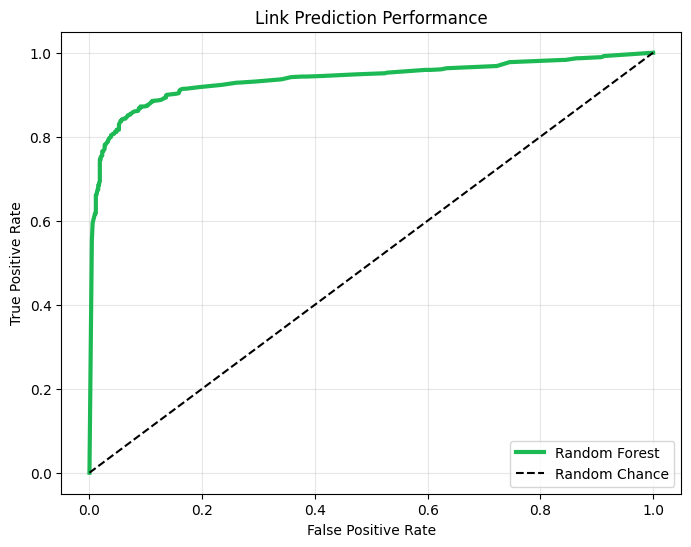

In [ ]:
# This script attempts to predict future collaborations between artists on Spotify.
# We treat the problem as a binary classification task and predict links using
# supervised learning. We construct a graph from past collaborations, extract
# network features and train a Random Forest classifier.

import pandas as pd
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, average_precision_score, confusion_matrix, roc_curve
from networkx.algorithms.community import louvain_communities
import requests
import io
import warnings
warnings.filterwarnings('ignore') # Clean up output

# PREPROCESSING & DATA INGESTION

# Our data sources are monthly collaboration edge lists
# These are hosted on GitHub because we used Google Colab and want to load in the
# data when this is run

FILES = [
    "https://raw.githubusercontent.com/akutsupis/spotify_collab_network/refs/heads/main/collab_edges_2024_november.csv",
    "https://raw.githubusercontent.com/akutsupis/spotify_collab_network/refs/heads/main/collab_edges_2024_december.csv",
    "https://raw.githubusercontent.com/akutsupis/spotify_collab_network/refs/heads/main/collab_edges_2025_january.csv",
    "https://raw.githubusercontent.com/akutsupis/spotify_collab_network/refs/heads/main/collab_edges_2025_february.csv",
    "https://raw.githubusercontent.com/akutsupis/spotify_collab_network/refs/heads/main/collab_edges_2025_march.csv",
    "https://raw.githubusercontent.com/akutsupis/spotify_collab_network/refs/heads/main/collab_edges_2025_april.csv",
    "https://raw.githubusercontent.com/akutsupis/spotify_collab_network/refs/heads/main/collab_edges_2025_may.csv",
    "https://raw.githubusercontent.com/akutsupis/spotify_collab_network/refs/heads/main/collab_edges_2025_june.csv",
    "https://raw.githubusercontent.com/akutsupis/spotify_collab_network/refs/heads/main/collab_edges_2025_july.csv",
    "https://raw.githubusercontent.com/akutsupis/spotify_collab_network/refs/heads/main/collab_edges_2025_august.csv",
    "https://raw.githubusercontent.com/akutsupis/spotify_collab_network/refs/heads/main/collab_edges_2025_september.csv",
    "https://raw.githubusercontent.com/akutsupis/spotify_collab_network/refs/heads/main/collab_edges_2025_october.csv"
]

def load_and_prep_data(file_list):
    """
    Reads the raw CSVs. We decided to combine all months into a single main dataframe
    and then sort IDs to ensure the graph is treated as Undirected.
    """
    dfs = []
    print("Reading Network Files...")
    for f in file_list:
        try:
            # This was for handling local files, no longer needed really
            if f.startswith("http"):
                df = pd.read_csv(f)
            else:
                df = pd.read_csv(f)

            # Standardize dates
            df['release_date'] = pd.to_datetime(df['release_date'], errors='coerce')
            dfs.append(df)
        except Exception as e:
            print(f"   WARNING: Skipping {f}: {e}")

    if not dfs: raise ValueError("WARNING: No data loaded.")

    main = pd.concat(dfs, ignore_index=True).dropna(subset=['release_date'])

    # Collaboration is inherently undirected (A feat B == B feat A).
    # We sort the IDs row-wise so that (Source, Target) is always (Low_ID, High_ID).
    # This removes duplicate edges like (A,B) and (B,A).
    ids = main[['artist_u_id', 'artist_v_id']].values
    ids.sort(axis=1)
    main['source'] = ids[:, 0]
    main['target'] = ids[:, 1]

    print(f"Main Dataset Ready: {len(main)} interactions.")
    return main

# COHORT SELECTION
def get_core_cohort(df, min_months=3):
    """
    We observed that many artists appear in the data for only one month and never return.
    Including them creates a very sparse graph which makes link prediction difficult.
    We filter for a 'Core Cohort' of artists active in at least `min_months` distinct months.
    """
    print("\n Identifying Core Cohort...")
    df['month_period'] = df['release_date'].dt.to_period('M')

    u_counts = df.groupby('artist_u_id')['month_period'].nunique()
    v_counts = df.groupby('artist_v_id')['month_period'].nunique()
    total_counts = u_counts.add(v_counts, fill_value=0)

    core_artists = total_counts[total_counts >= min_months].index.tolist()

    print(f"   Original Universe: {len(total_counts)} artists")
    print(f"   Core Cohort (Active >= {min_months} months): {len(core_artists)} persistent artists.")

    # Restrict the dataframe to interactions solely within this cohort
    core_df = df[
        (df['source'].isin(core_artists)) &
        (df['target'].isin(core_artists))
    ].copy()

    return core_df, core_artists

# FEATURE ENGINEERING
def compute_features(G_train, pairs):
    """
    Generates the features for the machine learning model.

    We selected 5 features based on the literature:
    1. Common Neighbors (CN): Basic metric of social proximity.
    2. Jaccard Coefficient: Normalized CN, accounts for node degree.
    3. Preferential Attachment: Captures the tendency of hubs to connect.
    4. Adamic-Adar: Weighted CN, gives more weight to rare shared neighbors.
    5. Community Membership: Boolean Y/N if they are in the same Louvain cluster.
    """
    data = []

    # A. Community Detection (Louvain)
    # We run community detection only on the training graph (G_train) to avoid leakage.
    print("   Detecting Communities (Louvain)...")
    try:
        communities = louvain_communities(G_train, seed=42)
        community_map = {}
        for idx, comm in enumerate(communities):
            for node in comm:
                community_map[node] = idx
    except Exception as e:
        print(f"   Community detection failed: {e}. Defaulting to 0.")
        community_map = {}

    degrees = dict(G_train.degree())

    print(f"   Computing features for {len(pairs)} pairs...")

    for u, v in pairs:
        # If an artist is not in G_train, they have no history.
        # We can't calculate features for those artists.
        if u not in G_train or v not in G_train:
            data.append([0, 0, 0, 0, 0])
            continue

        # 1. Common Neighbors
        cn = list(nx.common_neighbors(G_train, u, v))
        num_cn = len(cn)

        # 2. Jaccard Coefficient (Intersection / Union)
        denom = (degrees[u] + degrees[v] - num_cn)
        jaccard = num_cn / denom if denom > 0 else 0

        # 3. Preferential Attachment (Degree product)
        pref_attach = degrees[u] * degrees[v]

        # 4. Adamic-Adar Index
        # Penalizes shared neighbors that have very high degrees (popular hubs)
        adamic = sum(1 / np.log(degrees[n]) for n in cn if degrees[n] > 1)

        # 5. Community (Homophily)
        comm_u = community_map.get(u, -1)
        comm_v = community_map.get(v, -2)
        same_comm = 1 if comm_u == comm_v else 0

        data.append([num_cn, jaccard, pref_attach, adamic, same_comm])

    return np.array(data)

# TRAIN-TEST-SPLIT
def run_model(core_df, split_date):
    """
    Main driver for the link prediction pipeline.

    Methodology:
    1. Divide data into 'Past' (Train) and 'Future' (Test) based on a time block
    2. The graph is sparse, so we generate random non-edges (0 labels)
       to balance the dataset. We use a 1:1 ratio of Positives to Negatives.
    3. We use Random Forest because it handles non-linear relationships better
       than Logistic Regression and doesn't require feature scaling.
    """
    cutoff = pd.to_datetime(split_date)
    print(f"\nRunning Experiment: Cutoff {split_date}")

    # --- A. Construct Training Graph (Past Data) ---
    train_edges = core_df[core_df['release_date'] < cutoff]
    G_train = nx.from_pandas_edgelist(train_edges, 'source', 'target')
    # Create a set for O(1) lookups
    train_edge_set = set(zip(train_edges['source'], train_edges['target']))
    print(f"   Training Graph: {G_train.number_of_nodes()} nodes, {G_train.number_of_edges()} edges")

    # --- B. The Future (Target Labels) ---
    test_edges_df = core_df[core_df['release_date'] >= cutoff]
    true_future_edges = set(zip(test_edges_df['source'], test_edges_df['target']))
    print(f"   Target Future Edges: {len(true_future_edges)}")

    # --- C. Negative Sampling ---
    # We need examples of artists who did not collaborate to train the model.
    pos_samples = list(true_future_edges)
    all_nodes = list(G_train.nodes())
    neg_samples = []
    while len(neg_samples) < len(pos_samples):
        u, v = np.random.choice(all_nodes, 2, replace=False)
        if u > v: u, v = v, u # Maintain ID sorting
        if (u, v) not in true_future_edges:
            neg_samples.append((u, v))

    # Combine positive and negative samples
    all_pairs = pos_samples + neg_samples
    y_true = [1]*len(pos_samples) + [0]*len(neg_samples)

    # --- D. Compute Features ---
    X = compute_features(G_train, all_pairs)
    feature_names = ['Common Neighbors', 'Jaccard', 'Pref. Attachment', 'Adamic-Adar', 'Same Community']

    # --- E. Baseline Comparison ---
    # What if we assume that if they collaborated before, they will again?
    y_baseline = [1 if pair in train_edge_set else 0 for pair in all_pairs]
    baseline_auc = roc_auc_score(y_true, y_baseline)

    # --- F. Random Forest ---
    clf = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)

    # 70/30 Validation Split
    from sklearn.model_selection import train_test_split
    X_train, X_test, y_train, y_test, pairs_train, pairs_test = train_test_split(
        X, y_true, all_pairs, test_size=0.3, random_state=42
    )

    clf.fit(X_train, y_train)
    y_pred_proba = clf.predict_proba(X_test)[:, 1]

    # --- G. Evaluation ---
    rf_auc = roc_auc_score(y_test, y_pred_proba)
    ap_score = average_precision_score(y_test, y_pred_proba)

    print(f"\n Results:")
    print(f"   Baseline (Persistence) AUC: {baseline_auc:.4f}")
    print(f"   Random Forest Model AUC:    {rf_auc:.4f}")
    print(f"   Average Precision Score:    {ap_score:.4f}")

    print("\n   Feature Importance:")
    for name, imp in zip(feature_names, clf.feature_importances_):
        print(f"     {name}: {imp:.4f}")

    # --- H. New Links Only ---
    # We want to make sure the model is not just memorizing old links.
    test_pairs_set = [tuple(p) for p in pairs_test]
    is_recurrent = [1 if p in train_edge_set else 0 for p in test_pairs_set]

    df_res = pd.DataFrame({'y_true': y_test, 'y_prob': y_pred_proba, 'is_recurrent': is_recurrent})
    # Isolate predictions that are either new collaborations or negative samples
    subset_new = df_res[ (df_res['is_recurrent']==0) | (df_res['y_true']==0) ]
    if not subset_new.empty and subset_new['y_true'].nunique() > 1:
        auc_new = roc_auc_score(subset_new['y_true'], subset_new['y_prob'])
        print(f"   AUC on NEW LINKS ONLY:      {auc_new:.4f}")

    return clf, X_test, y_test, y_pred_proba, pairs_test, G_train

# ERROR ANALYSIS
def analyze_errors(clf, X_test, y_test, y_pred, pairs, G_train, node_map):
    """
    We look at high-probability predictions that turned out to be wrong (Label=0).
    These might represent potential collaborations that just haven't happened yet,
    But ultimately they have not happened yet.
    """
    print("\nError Analysis: Top False Positives")

    results = pd.DataFrame(X_test, columns=['CN', 'Jaccard', 'PA', 'Adamic', 'SameComm'])
    results['u_id'] = [p[0] for p in pairs]
    results['v_id'] = [p[1] for p in pairs]
    results['True_Label'] = y_test
    results['Predicted_Prob'] = y_pred

    # Which predictions was the model certain of but predicted wrong? (Prob > 0.8, Actual = 0)
    fp_cases = results[(results['True_Label'] == 0) & (results['Predicted_Prob'] > 0.8)].sort_values('Predicted_Prob', ascending=False)

    if fp_cases.empty:
        print("   WARNING: No high-confidence False Positives found.")
        print("   WARNING: If you're seeing this there's probably leakage somewhere.")
        return

    for idx, row in fp_cases.head(5).iterrows():
        # Map IDs back to names so we cann read them
        u_name = node_map.get(row['u_id'], row['u_id'])
        v_name = node_map.get(row['v_id'], row['v_id'])
        print(f"\n   Predicted Link: {u_name} -- {v_name}")
        print(f"     Probability: {row['Predicted_Prob']:.2f}")
        print(f"     Community Check: {'Same Community' if row['SameComm']==1 else 'Different Communities'}")
        print(f"     Shared Friends (CN): {row['CN']}")

# --- MAIN EXECUTION ---

if __name__ == "__main__":
    # Load Data
    main = load_and_prep_data(FILES)

    # Filter (Using x months as persistence threshold)
    core_df, core_ids = get_core_cohort(main, min_months=3)

    # Create Name Mapper for readability
    names = pd.concat([
        main[['artist_u_id', 'artist_u_name']].rename(columns={'artist_u_id':'id', 'artist_u_name':'name'}),
        main[['artist_v_id', 'artist_v_name']].rename(columns={'artist_v_id':'id', 'artist_v_name':'name'})
    ]).drop_duplicates('id').set_index('id')['name'].to_dict()

    # Run
    # We used May 1st, 2025 as the split to have a good balance of Past vs Future data
    model, X_test, y_test, preds, test_pairs, G_history = run_model(core_df, split_date='2025-05-01')

    # Analyze
    if model:
        analyze_errors(model, X_test, y_test, preds, test_pairs, G_history, names)

        # Plot ROC
        fpr, tpr, _ = roc_curve(y_test, preds)
        plt.figure(figsize=(8, 6))
        plt.plot(fpr, tpr, label='Random Forest', color='#1db954', linewidth=3)
        plt.plot([0, 1], [0, 1], 'k--', label='Random Chance')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Link Prediction Performance')
        plt.legend()
        plt.grid(alpha=0.3)
        plt.show()

Core graph: 1247 nodes, 4095 edges
Largest component: 1158 nodes, 3908 edges


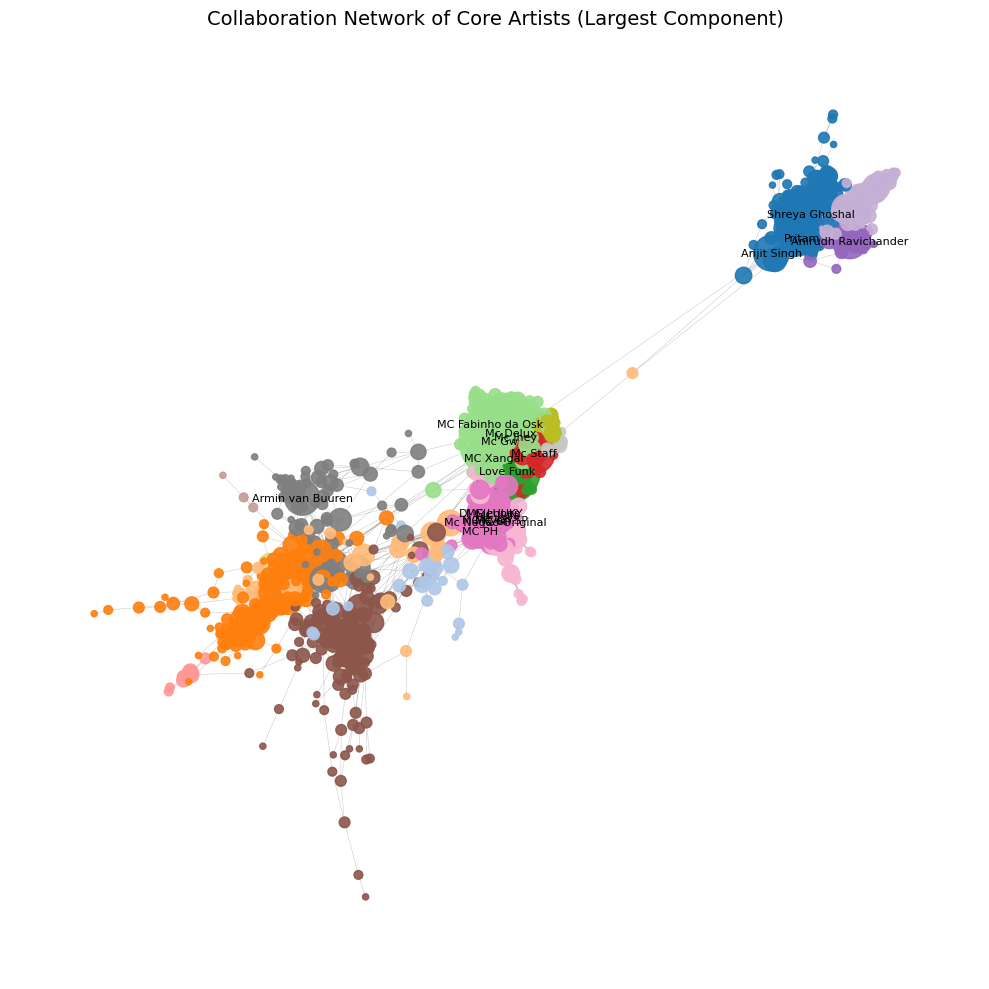

In [ ]:
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
from networkx.algorithms.community import louvain_communities

# GRAPH CONSTRUCTION
# We construct the full weighted collaboration graph using the cohort
# identified in the previous step. We use edge weights to represent the
# frequency of collaboration, which will later influence the visualization layout.

# -------------------------------------------------------------------
# 1. Build the Graph
# -------------------------------------------------------------------
G_core = nx.Graph()

# Aggregate all collaborations between core artists
# We iterate through the dataframe to sum weights for repeated collaborations
for _, row in core_df.iterrows():
    u = row["source"]
    v = row["target"]
    if u == v:
        continue  # We skip self-loops as we are interested in inter-artist connections
    if G_core.has_edge(u, v):
        G_core[u][v]["weight"] += 1
    else:
        G_core.add_edge(u, v, weight=1)

print(f"Core graph: {G_core.number_of_nodes()} nodes, {G_core.number_of_edges()} edges")

# -------------------------------------------------------------------
# 2. Filter for Largest Connected Component
# -------------------------------------------------------------------
# Visualizing disconnected components often results in a cluttered plot where
# small islands drift too far from the center. We decided to visualize only
# the LCC to focus on the main social structure.

if G_core.number_of_nodes() == 0:
    raise ValueError("WARNING: Core graph is empty. Check upstream filtering.")

largest_cc = max(nx.connected_components(G_core), key=len)
H = G_core.subgraph(largest_cc).copy()
print(f"Largest component: {H.number_of_nodes()} nodes, {H.number_of_edges()} edges")

# We add degree as a node attribute to scale node sizes later
deg = dict(H.degree())
nx.set_node_attributes(H, deg, "degree")

# Add artist names as an attribute (mapping from IDs to human-readable names)
for node in H.nodes():
    H.nodes[node]["name"] = names.get(node, str(node))

# -------------------------------------------------------------------
# 3. Community Detection for Visualization
# -------------------------------------------------------------------
# We re-run Louvain community detection here specifically for the purpose
# of color-coding the nodes in the visualization. This helps us visually
# verify if the graph structure aligns with genre/social clusters.

communities = louvain_communities(H, seed=42)
community_map = {}
for cid, comm in enumerate(communities):
    for node in comm:
        community_map[node] = cid

num_comms = len(communities)
cmap = plt.get_cmap("tab20")

# Map communities to colors
node_colors = [cmap(community_map[n] % 20) for n in H.nodes()]

# -------------------------------------------------------------------
# 4. Layout & Rendering
# -------------------------------------------------------------------

# We use the Spring Layout (Fruchterman-Reingold).
# This force-directed algorithm places connected nodes closer together,
# effectively revealing clusters naturally.
pos = nx.spring_layout(H, k=0.4, iterations=200, seed=42)

# Node sizes are proportional to degree (Hubs appear larger)
node_sizes = [H.nodes[n]["degree"] * 20 for n in H.nodes()]

# Edge widths are proportional to weight (Frequent collaborators have thicker lines)
edge_weights = [H[u][v].get("weight", 1) for u, v in H.edges()]
if edge_weights:
    max_w = max(edge_weights)
    # Normalize weights for clearer plotting
    edge_widths = [0.3 + 2.7 * (w / max_w) for w in edge_weights]
else:
    edge_widths = 0.5

plt.figure(figsize=(10, 10))

# Draw edges
nx.draw_networkx_edges(
    H,
    pos,
    width=edge_widths,
    alpha=0.25
)

# Draw nodes
nx.draw_networkx_nodes(
    H,
    pos,
    node_size=node_sizes,
    node_color=node_colors,
    alpha=0.9
)

# Labeling Strategy:
# Labeling every node creates an unreadable "hairball".
# We chose to label only the top K hubs (by degree) to provide context
# without overcrowding the figure.
K_LABEL = 20
top_nodes = sorted(deg, key=deg.get, reverse=True)[:K_LABEL]
labels = {n: H.nodes[n].get("name", str(n)) for n in top_nodes}

nx.draw_networkx_labels(
    H,
    pos,
    labels=labels,
    font_size=8
)

plt.title("Collaboration Network of Core Artists (Largest Component)", fontsize=14)
plt.axis("off")
plt.tight_layout()
plt.show()

In [ ]:
# This script extends our analysis into predicting artist popularity.
# We aim to predict an artist's future popularity via their listener count based on
# the structure of their collaboration network in the previous month.
#
# METHODOLOGY:
# 1. We join monthly collaboration graphs with monthly listener counts.
# 2. We extract centrality measures (Degree, PageRank, etc.)
#    and generate temporal features (Lags and Deltas) to capture momentum.
# 3. We compare a linear baseline (Ridge) against a non-linear model
#    (Random Forest) to see if network complexity adds predictive value.

import pandas as pd
import numpy as np
import networkx as nx
from dataclasses import dataclass
from typing import List, Dict

from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, r2_score

import warnings
# We suppress warnings to keep the output clean for the final report submission
warnings.filterwarnings("ignore")

# CONFIGURATION

@dataclass
class MonthSpec:
    month_str: str        # e.g. "2025-06"  (YYYY-MM)
    edges_file: str       # path to collab_edges_2025_june.csv
    listeners_file: str   # path to June_listeners1.csv

# We defined a configuration list here to easily swap out data sources or
# change the URL roots without modifying the logic loop below.
MONTH_CONFIG: List[MonthSpec] = [

    MonthSpec(month_str="2024-11",
              edges_file="https://raw.githubusercontent.com/akutsupis/spotify_collab_network/main/collab_edges_2024_november.csv",
              listeners_file="https://raw.githubusercontent.com/akutsupis/spotify_collab_network/main/November_listeners1.csv"),

    MonthSpec(month_str="2024-12",
              edges_file="https://raw.githubusercontent.com/akutsupis/spotify_collab_network/main/collab_edges_2024_december.csv",
              listeners_file="https://raw.githubusercontent.com/akutsupis/spotify_collab_network/main/December_listeners1.csv"),

    MonthSpec(month_str="2025-01",
              edges_file="https://raw.githubusercontent.com/akutsupis/spotify_collab_network/main/collab_edges_2025_january.csv",
              listeners_file="https://raw.githubusercontent.com/akutsupis/spotify_collab_network/main/January_listeners1.csv"),

    MonthSpec(month_str="2025-02",
              edges_file="https://raw.githubusercontent.com/akutsupis/spotify_collab_network/main/collab_edges_2025_february.csv",
              listeners_file="https://raw.githubusercontent.com/akutsupis/spotify_collab_network/main/February_listeners1.csv"),

    MonthSpec(month_str="2025-03",
              edges_file="https://raw.githubusercontent.com/akutsupis/spotify_collab_network/main/collab_edges_2025_march.csv",
              listeners_file="https://raw.githubusercontent.com/akutsupis/spotify_collab_network/main/March_listeners1.csv"),

    MonthSpec(month_str="2025-04",
              edges_file="https://raw.githubusercontent.com/akutsupis/spotify_collab_network/main/collab_edges_2025_april.csv",
              listeners_file="https://raw.githubusercontent.com/akutsupis/spotify_collab_network/main/April_listeners1.csv"),

    MonthSpec(month_str="2025-05",
              edges_file="https://raw.githubusercontent.com/akutsupis/spotify_collab_network/main/collab_edges_2025_may.csv",
              listeners_file="https://raw.githubusercontent.com/akutsupis/spotify_collab_network/main/May_listeners1.csv"),

    MonthSpec(month_str="2025-06",
              edges_file="https://raw.githubusercontent.com/akutsupis/spotify_collab_network/main/collab_edges_2025_june.csv",
              listeners_file="https://raw.githubusercontent.com/akutsupis/spotify_collab_network/main/June_listeners1.csv"),

    MonthSpec(month_str="2025-07",
              edges_file="https://raw.githubusercontent.com/akutsupis/spotify_collab_network/main/collab_edges_2025_july.csv",
              listeners_file="https://raw.githubusercontent.com/akutsupis/spotify_collab_network/main/July_listeners1.csv"),

    MonthSpec(month_str="2025-08",
              edges_file="https://raw.githubusercontent.com/akutsupis/spotify_collab_network/main/collab_edges_2025_august.csv",
              listeners_file="https://raw.githubusercontent.com/akutsupis/spotify_collab_network/main/August_listeners1.csv"),

    MonthSpec(month_str="2025-09",
              edges_file="https://raw.githubusercontent.com/akutsupis/spotify_collab_network/main/collab_edges_2025_september.csv",
              listeners_file="https://raw.githubusercontent.com/akutsupis/spotify_collab_network/main/September_listeners1.csv"),

    MonthSpec(month_str="2025-10",
              edges_file="https://raw.githubusercontent.com/akutsupis/spotify_collab_network/main/collab_edges_2025_october.csv",
              listeners_file="https://raw.githubusercontent.com/akutsupis/spotify_collab_network/main/October_listeners1.csv"),
]


MIN_ACTIVE_MONTHS = 3   # Core cohort threshold to reduce noise
RANDOM_STATE = 42


# ------------------------------------------------------------------------------
# 1. BASIC UTILITIES
# ------------------------------------------------------------------------------

def _clean_listeners_series(s: pd.Series) -> pd.Series:
    """
    Helper to clean the raw string format from Spotify (e.g. '115,378,988' -> float).
    """
    return (
        s.astype(str)
         .str.replace(",", "", regex=False)
         .str.strip()
         .replace("", np.nan)
         .astype(float)
    )


# ------------------------------------------------------------------------------
# 2. LOAD & ALIGN DATA
# ------------------------------------------------------------------------------

def load_all_edges(month_specs: List[MonthSpec]) -> pd.DataFrame:
    """
    Load all collab_edges CSVs and concatenate them into a main list.

    Returns dataframe with columns:
        ['month', 'artist_u_name', 'artist_v_name', 'weight']
    where weight is the number of collaborations in that month.
    """
    dfs = []
    print("Loading collaboration edges...")
    for spec in month_specs:
        df = pd.read_csv(spec.edges_file)
        # Ensure release_date is parsed
        df["release_date"] = pd.to_datetime(df["release_date"], errors="coerce")
        df["month"] = pd.Period(spec.month_str, freq="M")

        # We aggregate repeated (u, v) pairs within the month as edge weight.
        # We used artist_name instead of ID here to ensure easier joining with the Listeners data.
        df["artist_u_name"] = df["artist_u_name"].astype(str).str.strip()
        df["artist_v_name"] = df["artist_v_name"].astype(str).str.strip()

        grouped = (
            df.groupby(["month", "artist_u_name", "artist_v_name"], as_index=False)
              .size()
              .rename(columns={"size": "weight"})
        )
        dfs.append(grouped)

    edges_all = pd.concat(dfs, ignore_index=True)
    print(f"   Loaded {len(edges_all)} aggregated edges over {len(month_specs)} months.")
    return edges_all


def load_all_listeners(month_specs: List[MonthSpec]) -> pd.DataFrame:
    """
    Load all monthly listeners CSVs and concatenate.
    """
    dfs = []
    print("\nLoading listeners snapshots...")
    for spec in month_specs:
        df = pd.read_csv(spec.listeners_file)

        # Standardizing column names
        df["artist_name"] = df["Artist"].astype(str).str.strip()
        df["listeners"] = _clean_listeners_series(df["Listeners"])
        df["month"] = pd.Period(spec.month_str, freq="M")

        dfs.append(df[["month", "artist_name", "listeners"]])

    listeners_all = pd.concat(dfs, ignore_index=True)
    print(f"   Loaded {len(listeners_all)} artist-month listener records (raw).")
    return listeners_all


# ------------------------------------------------------------------------------
# 3. CORE COHORT FILTER
# ------------------------------------------------------------------------------

def filter_core_artists(edges_all: pd.DataFrame,
                        min_months: int = MIN_ACTIVE_MONTHS) -> pd.DataFrame:
    """
    Restrict to a 'core cohort' of artists active in >= min_months.

    Rationale: Consistent with our Link Prediction approach, we remove transient
    artists who only appear for a single month, as they introduce noise into the
    time-series analysis.
    """
    print("\nIdentifying Core Cohort...")

    u_months = edges_all.groupby("artist_u_name")["month"].nunique()
    v_months = edges_all.groupby("artist_v_name")["month"].nunique()
    total_months = u_months.add(v_months, fill_value=0)

    core_artists = total_months[total_months >= min_months].index.tolist()

    print(f"   Total unique artists in edges: {len(total_months)}")
    print(f"   Core artists (>= {min_months} months active): {len(core_artists)}")

    core_edges = edges_all[
        edges_all["artist_u_name"].isin(core_artists)
        & edges_all["artist_v_name"].isin(core_artists)
    ].copy()

    return core_edges, core_artists


# ------------------------------------------------------------------------------
# 4. NETWORK FEATURE EXTRACTION FOR EACH MONTH
# ------------------------------------------------------------------------------

def compute_month_graph_features(edges_month: pd.DataFrame) -> pd.DataFrame:
    """
    Given edges for one month, build an undirected weighted graph and compute node-level features.

    Features Selected:
    1. Degree/Strength: Volume of collaboration.
    2. Betweenness/Closeness: Position in the network (Brokerage).
    3. PageRank: Influence (Quality of connections).
    4. Clustering: Local cohesion.
    """
    # Build graph
    G = nx.Graph()
    for _, row in edges_month.iterrows():
        u, v, w = row["artist_u_name"], row["artist_v_name"], row["weight"]
        if G.has_edge(u, v):
            G[u][v]["weight"] += w
        else:
            G.add_edge(u, v, weight=w)

    # --- Centrality Calculation ---
    deg = dict(G.degree())
    strength = dict(G.degree(weight="weight"))

    # We included Betweenness Centrality, though we note it is computationally expensive O(VE).
    # For larger graphs, we might need to use k-centrality (approximation), but here it fits.
    betweenness = nx.betweenness_centrality(G, weight="weight", normalized=True)

    closeness = nx.closeness_centrality(G)
    pagerank = nx.pagerank(G, weight="weight")
    clustering = nx.clustering(G, weight="weight")

    df = pd.DataFrame({
        "deg": pd.Series(deg),
        "strength": pd.Series(strength),
        "betweenness": pd.Series(betweenness),
        "closeness": pd.Series(closeness),
        "pagerank": pd.Series(pagerank),
        "clustering": pd.Series(clustering),
    })

    df.index.name = "artist_name"
    return df


def build_panel_features(core_edges: pd.DataFrame,
                         listeners_all: pd.DataFrame) -> pd.DataFrame:
    """
    Constructs the Panel Data.
    For each month, we calculate the network features from the graph, and then
    LEFT JOIN the listeners data for that specific month.
    """
    print("\nBuilding monthly network features...")

    panel_dfs = []
    for month, df_month in core_edges.groupby("month"):
        print(f"   Month {month}: {len(df_month)} edges")

        features = compute_month_graph_features(df_month)
        features = features.reset_index()
        features["month"] = month

        # Join listeners: only artists appearing in graph are kept
        month_listeners = listeners_all[listeners_all["month"] == month].copy()
        month_listeners["artist_name"] = month_listeners["artist_name"].astype(str).str.strip()

        merged = features.merge(
            month_listeners[["artist_name", "listeners"]],
            on="artist_name",
            how="left"
        )

        merged = merged.dropna(subset=["listeners"])
        panel_dfs.append(merged)

    panel = pd.concat(panel_dfs, ignore_index=True)
    print(f"\nPanel dataset ready: {len(panel)} artist-month rows.")
    return panel


# ------------------------------------------------------------------------------
# 5. TEMPORAL FEATURES & TARGET CONSTRUCTION
# ------------------------------------------------------------------------------

def add_temporal_features(panel: pd.DataFrame) -> pd.DataFrame:
    """
    Time-Series Feature Engineering.

    To predict future popularity, looking at the current state is not enough.
    We need to capture:
    1. Momentum (Delta): Is their degree growing or shrinking?
    2. History (Lags): What were their listeners last month?
    """
    print("\nConstructing temporal features...")

    panel = panel.copy()
    panel = panel.sort_values(["artist_name", "month"]).reset_index(drop=True)

    # group by artist and compute lags / rolling stats
    def _per_artist(group: pd.DataFrame) -> pd.DataFrame:
        group = group.sort_values("month")
        # lags for listeners (Auto-regressive features)
        group["listeners_lag1"] = group["listeners"].shift(1)
        group["listeners_lag2"] = group["listeners"].shift(2)

        # 3-month moving average baseline (Smoothing short term noise)
        group["listeners_ma3"] = (
            group["listeners"]
                .rolling(window=3, min_periods=1)
                .mean()
        )

        # lags and deltas for network features
        for col in ["deg", "strength", "pagerank", "clustering"]:
            group[f"{col}_lag1"] = group[col].shift(1)
            # Delta = Current - Previous
            group[f"{col}_delta1"] = group[col] - group[f"{col}_lag1"]

        # TARGET VARIABLE: Next month's listeners
        group["listeners_next"] = group["listeners"].shift(-1)

        return group

    panel = panel.groupby("artist_name", group_keys=False).apply(_per_artist)

    # We drop rows where we cannot calculate the target (the last month of data)
    panel = panel.dropna(subset=["listeners_next"]).reset_index(drop=True)

    print(f"   After temporal construction: {len(panel)} rows with valid target.")
    return panel


# ------------------------------------------------------------------------------
# 6. TRAIN / TEST SPLIT BY TIME
# ------------------------------------------------------------------------------

def time_based_split(panel: pd.DataFrame, n_test_months: int = 2):
    """
    CRITICAL STEP: Time-based splitting.

    We cannot use random shuffling (standard train_test_split) because that would
    cause Data Leakage (training on future data to predict the past).
    We explicitly withhold the last `n_test_months` for evaluation.
    """
    unique_months = sorted(panel["month"].unique())
    if len(unique_months) <= n_test_months:
        raise ValueError("WARNING: Not enough months for a train/test split.")

    test_months = unique_months[-n_test_months:]
    train_months = unique_months[:-n_test_months]

    train_df = panel[panel["month"].isin(train_months)].copy()
    test_df = panel[panel["month"].isin(test_months)].copy()

    print("\nTime-based Split:")
    print(f"   Train months: {train_months}")
    print(f"   Test  months: {test_months}")
    print(f"   Train size: {len(train_df)}, Test size: {len(test_df)}")

    return train_df, test_df


# ------------------------------------------------------------------------------
# 7. EVALUATION HELPERS
# ------------------------------------------------------------------------------

def mape(y_true, y_pred):
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    # avoid division by zero
    mask = y_true != 0
    return np.mean(np.abs((y_true[mask] - y_pred[mask]) / y_true[mask])) * 100


def evaluate_regression(y_true, y_pred, label: str):
    mae = mean_absolute_error(y_true, y_pred)
    mape_val = mape(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)

    print(f"\n {label}")
    print(f"   MAE : {mae:,.2f}")
    print(f"   MAPE: {mape_val:,.2f}%")
    print(f"   R^2 : {r2:,.4f}")


# ------------------------------------------------------------------------------
# 8. MAIN PIPELINE
# ------------------------------------------------------------------------------

def main():
    # 1) Load raw data
    edges_all = load_all_edges(MONTH_CONFIG)
    listeners_all = load_all_listeners(MONTH_CONFIG)

    # 2) Core cohort filter
    core_edges, core_artists = filter_core_artists(edges_all, MIN_ACTIVE_MONTHS)

    # 3) Build panel with network features + listeners
    panel = build_panel_features(core_edges, listeners_all)

    # 4) Temporal features + next-month target
    panel = add_temporal_features(panel)

    # 5) Train/test split by month
    train_df, test_df = time_based_split(panel, n_test_months=2)

    # ---------------- Baselines ----------------
    y_train = train_df["listeners_next"].values
    y_test = test_df["listeners_next"].values

    # Baseline 1: Persistence  (L_{t+1} = L_t)
    # The assumption that "nothing changes" is surprisingly hard to beat in short timeframes.
    baseline_persist_pred = test_df["listeners"].values
    evaluate_regression(y_test, baseline_persist_pred,
                        label="Baseline 1: Persistence (L_next = L_t)")

    # Baseline 2: Moving Average (3 months)
    baseline_ma3_pred = test_df["listeners_ma3"].values
    evaluate_regression(y_test, baseline_ma3_pred,
                        label="Baseline 2: 3-month Moving Average")

    # ---------------- Model 1: Ridge (Linear) ----------------
    # We use Ridge regression to handle potential multicollinearity between features.
    feature_cols_model1 = [
        "deg", "strength", "pagerank", "clustering",
        "listeners", "listeners_lag1", "listeners_ma3",
        "deg_delta1", "strength_delta1", "pagerank_delta1", "clustering_delta1",
    ]

    # Fill NaNs with 0 (safe for sparse network features)
    for col in feature_cols_model1:
        train_df[col] = train_df[col].fillna(0.0)
        test_df[col] = test_df[col].fillna(0.0)

    X_train_m1 = train_df[feature_cols_model1].values
    X_test_m1 = test_df[feature_cols_model1].values

    ridge = Ridge(alpha=1.0, random_state=RANDOM_STATE)
    ridge.fit(X_train_m1, y_train)
    y_pred_m1 = ridge.predict(X_test_m1)

    evaluate_regression(y_test, y_pred_m1,
                        label="Model 1: Ridge Regression (Single-month + Delta features)")

    # ---------------- Model 2: Random Forest (Non-Linear) ----------------
    # We test if non-linear interactions (e.g., High Degree + Low Clustering) provide better lift.
    feature_cols_model2 = feature_cols_model1 + [
        "listeners_lag2",
        "deg_lag1", "strength_lag1", "pagerank_lag1", "clustering_lag1",
    ]

    for col in feature_cols_model2:
        train_df[col] = train_df[col].fillna(0.0)
        test_df[col] = test_df[col].fillna(0.0)

    X_train_m2 = train_df[feature_cols_model2].values
    X_test_m2 = test_df[feature_cols_model2].values

    rf = RandomForestRegressor(
        n_estimators=300,
        max_depth=None,
        random_state=RANDOM_STATE,
        n_jobs=-1
    )
    rf.fit(X_train_m2, y_train)
    y_pred_m2 = rf.predict(X_test_m2)

    evaluate_regression(y_test, y_pred_m2,
                        label="Model 2: Random Forest (Sliding-window features)")

    # Feature importance analysis
    importances = rf.feature_importances_
    print("\n   Random Forest Feature Importances:")
    for name, imp in sorted(zip(feature_cols_model2, importances),
                            key=lambda x: x[1], reverse=True):
        print(f"     {name:20s}: {imp:.4f}")


# ------------------------------------------------------------------------------
# ENTRY POINT
# ------------------------------------------------------------------------------

if __name__ == "__main__":
    main()

Loading collaboration edges...
   Loaded 18797 aggregated edges over 12 months.

Loading listeners snapshots...
   Loaded 15698 artist-month listener records (raw).

Identifying Core Cohort...
   Total unique artists in edges: 6673
   Core artists (>= 3 months active): 1277

Building monthly network features...
   Month 2024-11: 546 edges
   Month 2024-12: 869 edges
   Month 2025-01: 238 edges
   Month 2025-02: 566 edges
   Month 2025-03: 372 edges
   Month 2025-04: 393 edges
   Month 2025-05: 464 edges
   Month 2025-06: 514 edges
   Month 2025-07: 511 edges
   Month 2025-08: 424 edges
   Month 2025-09: 706 edges
   Month 2025-10: 676 edges

Panel dataset ready: 1648 artist-month rows.

Constructing temporal features...
   After temporal construction: 1172 rows with valid target.

Time-based Split:
   Train months: [Period('2024-11', 'M'), Period('2024-12', 'M'), Period('2025-01', 'M'), Period('2025-02', 'M'), Period('2025-03', 'M'), Period('2025-04', 'M'), Period('2025-05', 'M'), Peri

In [ ]:
def add_relative_targets(panel: pd.DataFrame) -> pd.DataFrame:
    """
    Predicting raw listener counts is problematic because the values span several orders
    of magnitude (from 10k to 100M). A model predicting raw values will be biased
    towards high-listener artists.

    We convert to 'log_diff' logarithmic growth rate to standardize
    the series and focus on relative growth rather than absolute magnitude.
    """
    panel = panel.copy()
    panel["log_listeners"] = np.log1p(panel["listeners"])
    panel["log_listeners_next"] = np.log1p(panel["listeners_next"])

    # Target: The change in log listeners (approx % growth)
    panel["log_diff"] = panel["log_listeners_next"] - panel["log_listeners"]

    eps = 1e-9
    # We also calculate raw percentage growth
    panel["growth_rate"] = np.where(
        panel["listeners"] > 0,
        (panel["listeners_next"] - panel["listeners"]) / (panel["listeners"] + eps),
        np.nan,
    )

    panel = panel.dropna(subset=["log_diff"])
    return panel


# ---------------------------------------------------------------------
# 5. NEW COLLAB FLAGS & LOCAL FEATURES
# ---------------------------------------------------------------------

def compute_new_collab_flags(edges_df: pd.DataFrame) -> pd.DataFrame:
    """
    This function tracks the history of pairs to flag if a collaboration in month 't'
    is the first time these two artists have interacted in our dataset.
    """
    df = edges_df[["month", "artist_u_name", "artist_v_name"]].copy()
    df["month"] = df["month"].astype("period[M]")

    seen_pairs = set()
    new_counts = {}

    for month in sorted(df["month"].unique()):
        mdf = df[df["month"] == month]
        for _, row in mdf.iterrows():
            u = row["artist_u_name"]
            v = row["artist_v_name"]
            # Enforce undirected sorting for pair tracking
            a, b = sorted([u, v])
            pair = (a, b)

            if pair not in seen_pairs:
                seen_pairs.add(pair)
                # Increment counter for both artists involved
                new_counts[(month, u)] = new_counts.get((month, u), 0) + 1
                new_counts[(month, v)] = new_counts.get((month, v), 0) + 1

    records = []
    for (month, artist), cnt in new_counts.items():
        records.append(
            {
                "month": month,
                "artist_name": artist,
                "num_new_partners": cnt,
                "has_new_collab": 1,
            }
        )

    flags_df = pd.DataFrame(records)
    if flags_df.empty:
        flags_df = pd.DataFrame(
            columns=["month", "artist_name", "num_new_partners", "has_new_collab"]
        )

    flags_df["num_new_partners"] = flags_df["num_new_partners"].fillna(0).astype(int)
    flags_df["has_new_collab"] = flags_df["has_new_collab"].fillna(0).astype(int)
    return flags_df


def add_local_collab_features(edges_df: pd.DataFrame,
                              listeners_all: pd.DataFrame,
                              panel: pd.DataFrame) -> pd.DataFrame:
    """
    A high degree is not enough context. Who you collaborate with matters.
    We calculate features regarding the *quality* of an artist's neighbors:
    1. avg_partner_listeners: Are they working with popular or obscure artists?
    2. upward_share: What % of their collaborators have more listeners than they do?
    """
    df_edges = edges_df[["month", "artist_u_name", "artist_v_name"]].copy()
    df_edges["month"] = df_edges["month"].astype("period[M]")

    df_list = listeners_all[["month", "artist_name", "listeners"]].copy()
    df_list["month"] = df_list["month"].astype("period[M]")

    records = []

    for month, mdf in df_edges.groupby("month"):
        # Create a lookup for listener counts in this specific month
        mlist = df_list[df_list["month"] == month]
        l_map = dict(zip(mlist["artist_name"], mlist["listeners"]))

        # Build adjacency list
        neigh = {}
        for _, row in mdf.iterrows():
            u = row["artist_u_name"]
            v = row["artist_v_name"]
            neigh.setdefault(u, set()).add(v)
            neigh.setdefault(v, set()).add(u)

        for artist, partners in neigh.items():
            self_l = l_map.get(artist, np.nan)
            partner_ls = [l_map.get(p, np.nan) for p in partners]
            partner_ls = [x for x in partner_ls if pd.notna(x)]

            num_partners = len(partners)
            avg_partner_l = float(np.mean(partner_ls)) if partner_ls else np.nan

            if pd.notna(self_l) and partner_ls:
                # "Upward" means the partner has MORE listeners than the ego artist
                upward_count = sum(pl > self_l for pl in partner_ls)
                upward_share = upward_count / len(partner_ls)
                upward_any = 1 if upward_count > 0 else 0
            else:
                upward_share = np.nan
                upward_any = 0

            records.append(
                {
                    "month": month,
                    "artist_name": artist,
                    "num_partners": num_partners,
                    "avg_partner_listeners": avg_partner_l,
                    "upward_share": upward_share,
                    "upward_any": upward_any,
                }
            )

    local_df = pd.DataFrame(records)
    if local_df.empty:
        local_df = pd.DataFrame(
            columns=[
                "month",
                "artist_name",
                "num_partners",
                "avg_partner_listeners",
                "upward_share",
                "upward_any",
            ]
        )

    out = panel.copy()
    out["month"] = out["month"].astype("period[M]")
    out = out.merge(local_df, on=["artist_name", "month"], how="left")

    out["num_partners"] = out["num_partners"].fillna(0).astype(int)
    out["upward_any"] = out["upward_any"].fillna(0).astype(int)
    return out


# ---------------------------------------------------------------------
# 6. REGRESSION
# ---------------------------------------------------------------------

def run_relative_change_regression(panel_ext: pd.DataFrame):
    """
    Ridge Regression on Growth Rate (Log Difference).
    This model attempts to predict the rate of change.
    """
    df = panel_ext.dropna(subset=["log_diff"]).copy()
    train_df, test_df = time_based_split(df, n_test_months=2)

    y_train = train_df["log_diff"].values
    y_test = test_df["log_diff"].values

    feature_cols = [
        "deg",
        "strength",
        "pagerank",
        "clustering",
        "listeners",
        "listeners_lag1",
        "listeners_ma3",
        "deg_delta1",
        "strength_delta1",
        "pagerank_delta1",
        "clustering_delta1",
        "num_new_partners",
        "has_new_collab",
        "num_partners",
        "avg_partner_listeners",
        "upward_share",
        "upward_any",
    ]

    for col in feature_cols:
        train_df[col] = train_df[col].fillna(0.0)
        test_df[col] = test_df[col].fillna(0.0)

    X_train = train_df[feature_cols].values
    X_test = test_df[feature_cols].values

    # Baseline: No Change (log_diff = 0)
    # This assumes the artist stays exactly as popular as they were.
    y_pred_baseline = np.zeros_like(y_test)
    mae_base = mean_absolute_error(y_test, y_pred_baseline)
    r2_base = r2_score(y_test, y_pred_baseline)

    ridge = Ridge(alpha=1.0, random_state=RANDOM_STATE)
    ridge.fit(X_train, y_train)
    y_pred = ridge.predict(X_test)

    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    print("\nRidge Regression on Relative Growth (log_diff)")
    print(f"   Baseline (Zero Growth) MAE : {mae_base:.4f}")
    print(f"   Baseline (Zero Growth) R^2 : {r2_base:.4f}")
    print(f"   Model MAE                  : {mae:.4f}")
    print(f"   Model R^2                  : {r2:.4f}")

    coefs = pd.Series(ridge.coef_, index=feature_cols).sort_values(ascending=False)
    print("\n   Top positive coefficients:")
    print(coefs.head(10))
    print("\n   Top negative coefficients:")
    print(coefs.tail(10))


def run_diff_in_diff(panel_ext: pd.DataFrame):
    """
    Causal Inference: Difference-in-Differences (DiD).

    We attempt a quasi-experimental design to measure the causal impact of
    collaborating with a NEW partner.

    Treatment Group: Artists who had a NEW collaboration in month t.
    Control Group: Artists who collaborated, but only with existing contacts.

    Outcome: Is there a change in growth velocity (Difference in differences).
    """
    df = panel_ext.copy()
    needed = ["listeners", "listeners_lag1", "listeners_next", "has_new_collab"]
    df = df.dropna(subset=needed)

    # Pre-change velocity vs Post-change velocity
    df["pre_change"] = df["listeners"] - df["listeners_lag1"]
    df["post_change"] = df["listeners_next"] - df["listeners"]

    # DiD = (Post - Pre)
    df["did_diff"] = df["post_change"] - df["pre_change"]
    df = df.dropna(subset=["pre_change", "post_change", "did_diff"])

    grp = df.groupby("has_new_collab")["did_diff"].agg(["mean", "std", "count"]).reset_index()

    print("\nDifference-in-Differences Analysis: Effect of Novel Collaboration")
    print(grp)

    if set(df["has_new_collab"].unique()) == {0, 1}:
        treated = df[df["has_new_collab"] == 1]["did_diff"].values
        control = df[df["has_new_collab"] == 0]["did_diff"].values

        m1, m0 = treated.mean(), control.mean()
        s1, s0 = treated.std(ddof=1), control.std(ddof=1)
        n1, n0 = len(treated), len(control)
        se = np.sqrt(s1**2 / n1 + s0**2 / n0)
        t_stat = (m1 - m0) / se if se > 0 else np.nan

        print("\n   Difference-in-means (Treated - Control):", m1 - m0)
        print("   Approx. t-stat (for significance):", t_stat)
    else:
        print("\n   WARNING: Only one group present in has_new_collab, cannot compare.")


# ---------------------------------------------------------------------
# 7. ENTRY POINT
# ---------------------------------------------------------------------

if __name__ == "__main__":
    # Step 1: Load data & build base panel
    edges_all = load_all_edges(MONTH_CONFIG)
    listeners_all = load_all_listeners(MONTH_CONFIG)
    core_edges, core_artists = filter_core_artists(edges_all, MIN_ACTIVE_MONTHS)
    panel = build_panel_features(core_edges, listeners_all)
    panel = add_temporal_features(panel)
    panel = add_relative_targets(panel)

    # Step 2: New-collab flags (Novelty features)
    flags_df = compute_new_collab_flags(core_edges)
    panel_ext = panel.merge(
        flags_df,
        on=["artist_name", "month"],
        how="left",
    )
    panel_ext["num_new_partners"] = panel_ext["num_new_partners"].fillna(0).astype(int)
    panel_ext["has_new_collab"] = panel_ext["has_new_collab"].fillna(0).astype(int)

    # Step 3: Local collab features (Quality features)
    panel_ext = add_local_collab_features(core_edges, listeners_all, panel_ext)

    # Step 4: Regression on relative change (Growth Prediction)
    run_relative_change_regression(panel_ext)

    # Step 5: Causal Inference (Diff-in-Diff)
    run_diff_in_diff(panel_ext)

Loading collaboration edges...
   Loaded 18797 aggregated edges over 12 months.

Loading listeners snapshots...
   Loaded 15698 artist-month listener records (raw).

Identifying Core Cohort...
   Total unique artists in edges: 6673
   Core artists (>= 3 months active): 1277

Building monthly network features...
   Month 2024-11: 546 edges
   Month 2024-12: 869 edges
   Month 2025-01: 238 edges
   Month 2025-02: 566 edges
   Month 2025-03: 372 edges
   Month 2025-04: 393 edges
   Month 2025-05: 464 edges
   Month 2025-06: 514 edges
   Month 2025-07: 511 edges
   Month 2025-08: 424 edges
   Month 2025-09: 706 edges
   Month 2025-10: 676 edges

Panel dataset ready: 1648 artist-month rows.

Constructing temporal features...
   After temporal construction: 1172 rows with valid target.

Time-based Split:
   Train months: [Period('2024-11', 'M'), Period('2024-12', 'M'), Period('2025-01', 'M'), Period('2025-02', 'M'), Period('2025-03', 'M'), Period('2025-04', 'M'), Period('2025-05', 'M'), Peri

Loading collaboration edges ...
   Loaded 18797 aggregated edges over 12 months.

Loading listeners snapshots ...
   Loaded 15698 artist-month listener records (raw).

Identifying Core Cohort ...
   Total unique artists in edges: 6673
   Core artists (>= 3 months active): 1277

 Building monthly network features ...
   Month 2024-11: 546 edges
   Month 2024-12: 869 edges
   Month 2025-01: 238 edges
   Month 2025-02: 566 edges
   Month 2025-03: 372 edges
   Month 2025-04: 393 edges
   Month 2025-05: 464 edges
   Month 2025-06: 514 edges
   Month 2025-07: 511 edges
   Month 2025-08: 424 edges
   Month 2025-09: 706 edges
   Month 2025-10: 676 edges

 Panel dataset ready: 1648 artist-month rows.

  Constructing temporal features ...
   After temporal construction: 1172 rows with valid target.

Time-based Split:
   Train months: [Period('2024-11', 'M'), Period('2024-12', 'M'), Period('2025-01', 'M'), Period('2025-02', 'M'), Period('2025-03', 'M'), Period('2025-04', 'M'), Period('2025-05', '

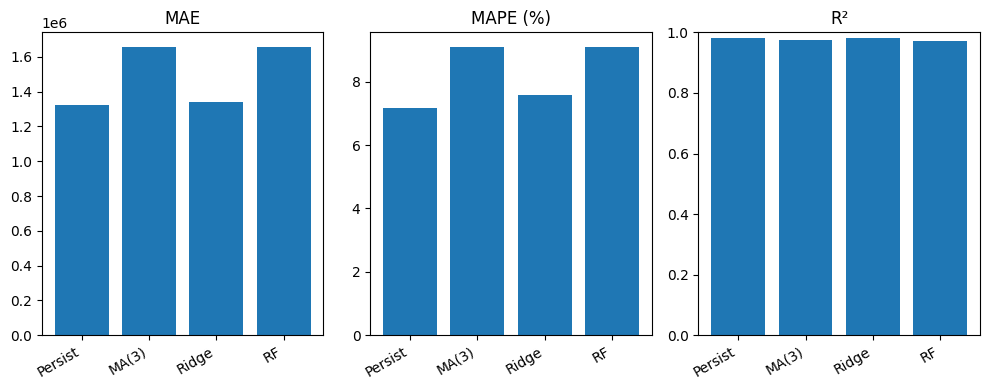


   Random Forest Feature Importances:
     listeners           : 0.7391
     listeners_ma3       : 0.2415
     pagerank            : 0.0051
     clustering          : 0.0023
     listeners_lag1      : 0.0017
     strength            : 0.0017
     pagerank_lag1       : 0.0012
     deg                 : 0.0012
     pagerank_delta1     : 0.0011
     listeners_lag2      : 0.0011
     clustering_delta1   : 0.0009
     strength_delta1     : 0.0008
     strength_lag1       : 0.0007
     deg_lag1            : 0.0007
     clustering_lag1     : 0.0006
     deg_delta1          : 0.0004


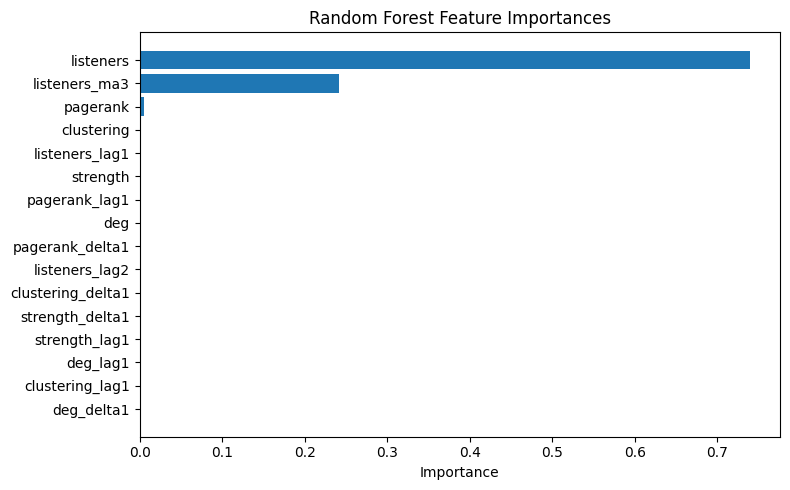

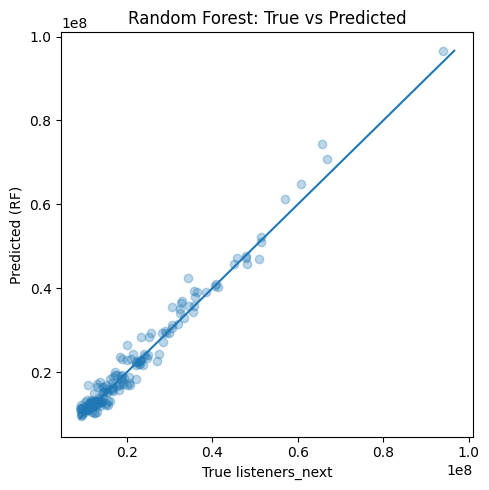

In [ ]:
# This script extends our pipeline with graphs.
# This version generates plots to help us interpret the results for the final presentation

import pandas as pd
import numpy as np
import networkx as nx
from dataclasses import dataclass
from typing import List

from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, r2_score

import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")


# ------------------------------------------------------------------------------
# 0. CONFIGURATION
# ------------------------------------------------------------------------------

@dataclass
class MonthSpec:
    month_str: str        # e.g. "2025-06"  (YYYY-MM)
    edges_file: str       # path to collab_edges_2025_june.csv
    listeners_file: str   # path to June_listeners1.csv


# Monthly file list
MONTH_CONFIG: List[MonthSpec] = [

    MonthSpec(month_str="2024-11",
              edges_file="https://raw.githubusercontent.com/akutsupis/spotify_collab_network/main/collab_edges_2024_november.csv",
              listeners_file="https://raw.githubusercontent.com/akutsupis/spotify_collab_network/main/November_listeners1.csv"),

    MonthSpec(month_str="2024-12",
              edges_file="https://raw.githubusercontent.com/akutsupis/spotify_collab_network/main/collab_edges_2024_december.csv",
              listeners_file="https://raw.githubusercontent.com/akutsupis/spotify_collab_network/main/December_listeners1.csv"),

    MonthSpec(month_str="2025-01",
              edges_file="https://raw.githubusercontent.com/akutsupis/spotify_collab_network/main/collab_edges_2025_january.csv",
              listeners_file="https://raw.githubusercontent.com/akutsupis/spotify_collab_network/main/January_listeners1.csv"),

    MonthSpec(month_str="2025-02",
              edges_file="https://raw.githubusercontent.com/akutsupis/spotify_collab_network/main/collab_edges_2025_february.csv",
              listeners_file="https://raw.githubusercontent.com/akutsupis/spotify_collab_network/main/February_listeners1.csv"),

    MonthSpec(month_str="2025-03",
              edges_file="https://raw.githubusercontent.com/akutsupis/spotify_collab_network/main/collab_edges_2025_march.csv",
              listeners_file="https://raw.githubusercontent.com/akutsupis/spotify_collab_network/main/March_listeners1.csv"),

    MonthSpec(month_str="2025-04",
              edges_file="https://raw.githubusercontent.com/akutsupis/spotify_collab_network/main/collab_edges_2025_april.csv",
              listeners_file="https://raw.githubusercontent.com/akutsupis/spotify_collab_network/main/April_listeners1.csv"),

    MonthSpec(month_str="2025-05",
              edges_file="https://raw.githubusercontent.com/akutsupis/spotify_collab_network/main/collab_edges_2025_may.csv",
              listeners_file="https://raw.githubusercontent.com/akutsupis/spotify_collab_network/main/May_listeners1.csv"),

    MonthSpec(month_str="2025-06",
              edges_file="https://raw.githubusercontent.com/akutsupis/spotify_collab_network/main/collab_edges_2025_june.csv",
              listeners_file="https://raw.githubusercontent.com/akutsupis/spotify_collab_network/main/June_listeners1.csv"),

    MonthSpec(month_str="2025-07",
              edges_file="https://raw.githubusercontent.com/akutsupis/spotify_collab_network/main/collab_edges_2025_july.csv",
              listeners_file="https://raw.githubusercontent.com/akutsupis/spotify_collab_network/main/July_listeners1.csv"),

    MonthSpec(month_str="2025-08",
              edges_file="https://raw.githubusercontent.com/akutsupis/spotify_collab_network/main/collab_edges_2025_august.csv",
              listeners_file="https://raw.githubusercontent.com/akutsupis/spotify_collab_network/main/August_listeners1.csv"),

    MonthSpec(month_str="2025-09",
              edges_file="https://raw.githubusercontent.com/akutsupis/spotify_collab_network/main/collab_edges_2025_september.csv",
              listeners_file="https://raw.githubusercontent.com/akutsupis/spotify_collab_network/main/September_listeners1.csv"),

    MonthSpec(month_str="2025-10",
              edges_file="https://raw.githubusercontent.com/akutsupis/spotify_collab_network/main/collab_edges_2025_october.csv",
              listeners_file="https://raw.githubusercontent.com/akutsupis/spotify_collab_network/main/October_listeners1.csv"),
]

MIN_ACTIVE_MONTHS = 3   # core cohort threshold
RANDOM_STATE = 42


# ---------------------------------------------------------------------
# 1. UTILITIES
# ---------------------------------------------------------------------

def _clean_listeners_series(s: pd.Series) -> pd.Series:
    """Convert '115,378,988' -> float 115378988.0"""
    return (
        s.astype(str)
         .str.replace(",", "", regex=False)
         .str.strip()
         .replace("", np.nan)
         .astype(float)
    )


# ---------------------------------------------------------------------
# 2. LOAD DATA
# ---------------------------------------------------------------------

def load_all_edges(month_specs: List[MonthSpec]) -> pd.DataFrame:
    """
    Load all collab_edges CSVs and concatenate.

    Returns dataframe with columns:
        ['month', 'artist_u_name', 'artist_v_name', 'weight']
    where weight is the number of collaborations in that month.
    """
    dfs = []
    print("Loading collaboration edges ...")
    for spec in month_specs:
        df = pd.read_csv(spec.edges_file)
        df["release_date"] = pd.to_datetime(df["release_date"], errors="coerce")
        df["month"] = pd.Period(spec.month_str, freq="M")

        df["artist_u_name"] = df["artist_u_name"].astype(str).str.strip()
        df["artist_v_name"] = df["artist_v_name"].astype(str).str.strip()

        grouped = (
            df.groupby(["month", "artist_u_name", "artist_v_name"], as_index=False)
              .size()
              .rename(columns={"size": "weight"})
        )
        dfs.append(grouped)

    edges_all = pd.concat(dfs, ignore_index=True)
    print(f"   Loaded {len(edges_all)} aggregated edges over {len(month_specs)} months.")
    return edges_all


def load_all_listeners(month_specs: List[MonthSpec]) -> pd.DataFrame:
    """
    Load all monthly listeners CSVs and concatenate.

    Returns dataframe with columns:
        ['month', 'artist_name', 'listeners']
    """
    dfs = []
    print("\nLoading listeners snapshots ...")
    for spec in month_specs:
        df = pd.read_csv(spec.listeners_file)

        df["artist_name"] = df["Artist"].astype(str).str.strip()
        df["listeners"] = _clean_listeners_series(df["Listeners"])
        df["month"] = pd.Period(spec.month_str, freq="M")

        dfs.append(df[["month", "artist_name", "listeners"]])

    listeners_all = pd.concat(dfs, ignore_index=True)
    print(f"   Loaded {len(listeners_all)} artist-month listener records (raw).")
    return listeners_all


# ---------------------------------------------------------------------
# 3. CORE COHORT FILTER
# ---------------------------------------------------------------------

def filter_core_artists(edges_all: pd.DataFrame,
                        min_months: int = MIN_ACTIVE_MONTHS):
    """
    We restrict to a 'Core Cohort' of artists active in >= min_months.

    Transient artists (one-hit wonders) introduce noise and sparsity.
    By filtering them out, we ensure we are modeling a stable social system.
    """
    print("\nIdentifying Core Cohort ...")

    u_months = edges_all.groupby("artist_u_name")["month"].nunique()
    v_months = edges_all.groupby("artist_v_name")["month"].nunique()
    total_months = u_months.add(v_months, fill_value=0)

    core_artists = total_months[total_months >= min_months].index.tolist()

    print(f"   Total unique artists in edges: {len(total_months)}")
    print(f"   Core artists (>= {min_months} months active): {len(core_artists)}")

    core_edges = edges_all[
        edges_all["artist_u_name"].isin(core_artists)
        & edges_all["artist_v_name"].isin(core_artists)
    ].copy()

    return core_edges, core_artists


# ---------------------------------------------------------------------
# 4. NETWORK FEATURES
# ---------------------------------------------------------------------

def compute_month_graph_features(edges_month: pd.DataFrame) -> pd.DataFrame:
    """
    Given edges for one month, build undirected weighted graph and compute
    node-level features (Centrality, PageRank, Clustering).
    """
    G = nx.Graph()
    for _, row in edges_month.iterrows():
        u, v, w = row["artist_u_name"], row["artist_v_name"], row["weight"]
        if G.has_edge(u, v):
            G[u][v]["weight"] += w
        else:
            G.add_edge(u, v, weight=w)

    # centralities
    deg = dict(G.degree())
    strength = dict(G.degree(weight="weight"))
    betweenness = nx.betweenness_centrality(G, weight="weight", normalized=True)
    closeness = nx.closeness_centrality(G)
    pagerank = nx.pagerank(G, weight="weight")
    clustering = nx.clustering(G, weight="weight")

    df = pd.DataFrame({
        "deg": pd.Series(deg),
        "strength": pd.Series(strength),
        "betweenness": pd.Series(betweenness),
        "closeness": pd.Series(closeness),
        "pagerank": pd.Series(pagerank),
        "clustering": pd.Series(clustering),
    })

    df.index.name = "artist_name"
    return df


def build_panel_features(core_edges: pd.DataFrame,
                         listeners_all: pd.DataFrame) -> pd.DataFrame:
    """
    For each month:
      - build month graph from core_edges
      - compute network features
      - join with listeners snapshot
    Then concatenate all months into one panel dataframe.
    """
    print("\n Building monthly network features ...")

    panel_dfs = []
    for month, df_month in core_edges.groupby("month"):
        print(f"   Month {month}: {len(df_month)} edges")

        features = compute_month_graph_features(df_month)
        features = features.reset_index()
        features["month"] = month

        month_listeners = listeners_all[listeners_all["month"] == month].copy()
        month_listeners["artist_name"] = month_listeners["artist_name"].astype(str).str.strip()

        merged = features.merge(
            month_listeners[["artist_name", "listeners"]],
            on="artist_name",
            how="left"
        )

        merged = merged.dropna(subset=["listeners"])
        panel_dfs.append(merged)

    panel = pd.concat(panel_dfs, ignore_index=True)
    print(f"\n Panel dataset ready: {len(panel)} artist-month rows.")
    return panel


# ---------------------------------------------------------------------
# 5. TEMPORAL FEATURES
# ---------------------------------------------------------------------

def add_temporal_features(panel: pd.DataFrame) -> pd.DataFrame:
    """
    We need to capture momentum.
    We add lag features (History) and delta features (Change) to the dataset.

    Target: 'listeners_next' (The raw listener count in the subsequent month).
    """
    print("\n  Constructing temporal features ...")

    panel = panel.copy()
    panel = panel.sort_values(["artist_name", "month"]).reset_index(drop=True)

    def _per_artist(group: pd.DataFrame) -> pd.DataFrame:
        group = group.sort_values("month")

        # lags for listeners
        group["listeners_lag1"] = group["listeners"].shift(1)
        group["listeners_lag2"] = group["listeners"].shift(2)

        # 3-month moving average (Smoothing)
        group["listeners_ma3"] = (
            group["listeners"]
                 .rolling(window=3, min_periods=1)
                 .mean()
        )

        # lags & deltas for network features
        for col in ["deg", "strength", "pagerank", "clustering"]:
            group[f"{col}_lag1"] = group[col].shift(1)
            group[f"{col}_delta1"] = group[col] - group[f"{col}_lag1"]

        # target
        group["listeners_next"] = group["listeners"].shift(-1)
        return group

    panel = panel.groupby("artist_name", group_keys=False).apply(_per_artist)
    panel = panel.dropna(subset=["listeners_next"]).reset_index(drop=True)

    print(f"   After temporal construction: {len(panel)} rows with valid target.")
    return panel


# ---------------------------------------------------------------------
# 6. TRAIN / TEST SPLIT
# ---------------------------------------------------------------------

def time_based_split(panel: pd.DataFrame, n_test_months: int = 2):
    """
    CRITICAL: Time-based splitting.

    Random shuffling causes Data Leakage (training on future data to predict past).
    We explicitly withhold the last `n_test_months` for evaluation.
    """
    unique_months = sorted(panel["month"].unique())
    if len(unique_months) <= n_test_months:
        raise ValueError("Not enough months for a train/test split.")

    test_months = unique_months[-n_test_months:]
    train_months = unique_months[:-n_test_months]

    train_df = panel[panel["month"].isin(train_months)].copy()
    test_df = panel[panel["month"].isin(test_months)].copy()

    print("\nTime-based Split:")
    print(f"   Train months: {train_months}")
    print(f"   Test  months: {test_months}")
    print(f"   Train size: {len(train_df)}, Test size: {len(test_df)}")

    return train_df, test_df


# ---------------------------------------------------------------------
# 7. EVALUATION HELPERS
# ---------------------------------------------------------------------

def mape(y_true, y_pred):
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    mask = y_true != 0
    return np.mean(np.abs((y_true[mask] - y_pred[mask]) / y_true[mask])) * 100


def evaluate_regression(y_true, y_pred, label: str):
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    mae = mean_absolute_error(y_true, y_pred)
    mape_val = mape(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)

    print(f"\n{label}")
    print(f"   MAE : {mae:,.2f}")
    print(f"   MAPE: {mape_val:,.2f}%")
    print(f"   R^2 : {r2:,.4f}")

    return {
        "model": label,
        "MAE": mae,
        "MAPE": mape_val,
        "R2": r2,
    }


# ---------------------------------------------------------------------
# 8. MAIN PIPELINE (+ VISUALIZATION)
# ---------------------------------------------------------------------

def main():
    # 1) Load raw data
    edges_all = load_all_edges(MONTH_CONFIG)
    listeners_all = load_all_listeners(MONTH_CONFIG)

    # 2) Core cohort filter
    core_edges, core_artists = filter_core_artists(edges_all, MIN_ACTIVE_MONTHS)

    # 3) Build panel with network features + listeners
    panel = build_panel_features(core_edges, listeners_all)

    # 4) Temporal features + next-month target
    panel = add_temporal_features(panel)

    # 5) Train/test split by month
    train_df, test_df = time_based_split(panel, n_test_months=2)

    # ---------------- Baselines ----------------
    y_train = train_df["listeners_next"].values
    y_test = test_df["listeners_next"].values

    metrics_list = []   # collect metrics for plotting

    # Baseline 1: Persistence  (L_{t+1} = L_t)
    baseline_persist_pred = test_df["listeners"].values
    metrics_list.append(
        evaluate_regression(y_test, baseline_persist_pred,
                            label="Baseline: Persistence")
    )

    # Baseline 2: Moving Average (3 months)
    baseline_ma3_pred = test_df["listeners_ma3"].values
    metrics_list.append(
        evaluate_regression(y_test, baseline_ma3_pred,
                            label="Baseline: MA(3)")
    )

    # ---------------- Model 1: Ridge Regression ----------------
    feature_cols_model1 = [
        "deg", "strength", "pagerank", "clustering",
        "listeners", "listeners_lag1", "listeners_ma3",
        "deg_delta1", "strength_delta1", "pagerank_delta1", "clustering_delta1",
    ]

    for col in feature_cols_model1:
        train_df[col] = train_df[col].fillna(0.0)
        test_df[col] = test_df[col].fillna(0.0)

    X_train_m1 = train_df[feature_cols_model1].values
    X_test_m1 = test_df[feature_cols_model1].values

    ridge = Ridge(alpha=1.0, random_state=RANDOM_STATE)
    ridge.fit(X_train_m1, y_train)
    y_pred_m1 = ridge.predict(X_test_m1)

    metrics_list.append(
        evaluate_regression(y_test, y_pred_m1,
                            label="Model 1: Ridge")
    )

    # ---------------- Model 2: Random Forest -------------------
    feature_cols_model2 = feature_cols_model1 + [
        "listeners_lag2",
        "deg_lag1", "strength_lag1", "pagerank_lag1", "clustering_lag1",
    ]

    for col in feature_cols_model2:
        train_df[col] = train_df[col].fillna(0.0)
        test_df[col] = test_df[col].fillna(0.0)

    X_train_m2 = train_df[feature_cols_model2].values
    X_test_m2 = test_df[feature_cols_model2].values

    rf = RandomForestRegressor(
        n_estimators=300,
        max_depth=None,
        random_state=RANDOM_STATE,
        n_jobs=-1
    )
    rf.fit(X_train_m2, y_train)
    y_pred_m2 = rf.predict(X_test_m2)

    metrics_list.append(
        evaluate_regression(y_test, y_pred_m2,
                            label="Model 2: Random Forest")
    )

    # ---------------- Visualization 1: Model Comparison --------
    metrics_df = pd.DataFrame(metrics_list)
    metrics_df["short_name"] = metrics_df["model"].replace({
        "Baseline: Persistence": "Persist",
        "Baseline: MA(3)": "MA(3)",
        "Model 1: Ridge": "Ridge",
        "Model 2: Random Forest": "RF",
    })

    plt.figure(figsize=(10, 4))

    # MAE
    plt.subplot(1, 3, 1)
    plt.bar(metrics_df["short_name"], metrics_df["MAE"])
    plt.title("MAE")
    plt.xticks(rotation=30, ha="right")

    # MAPE
    plt.subplot(1, 3, 2)
    plt.bar(metrics_df["short_name"], metrics_df["MAPE"])
    plt.title("MAPE (%)")
    plt.xticks(rotation=30, ha="right")

    # R^2
    plt.subplot(1, 3, 3)
    plt.bar(metrics_df["short_name"], metrics_df["R2"])
    plt.title("R²")
    plt.ylim(0, 1.0)
    plt.xticks(rotation=30, ha="right")

    plt.tight_layout()
    plt.show()

    # ---------------- Feature Importance -------------------
    importances = rf.feature_importances_
    print("\n   Random Forest Feature Importances:")
    for name, imp in sorted(zip(feature_cols_model2, importances),
                            key=lambda x: x[1], reverse=True):
        print(f"     {name:20s}: {imp:.4f}")

    fi_df = pd.DataFrame({
        "feature": feature_cols_model2,
        "importance": importances
    }).sort_values("importance", ascending=False)

    plt.figure(figsize=(8, 5))
    plt.barh(fi_df["feature"], fi_df["importance"])
    plt.gca().invert_yaxis()
    plt.xlabel("Importance")
    plt.title("Random Forest Feature Importances")
    plt.tight_layout()
    plt.show()

    # ---------------- True vs Predicted (RF) -------------------
    plt.figure(figsize=(5, 5))
    plt.scatter(y_test, y_pred_m2, alpha=0.3)
    max_val = max(y_test.max(), y_pred_m2.max())
    min_val = min(y_test.min(), y_pred_m2.min())
    plt.plot([min_val, max_val], [min_val, max_val])
    plt.xlabel("True listeners_next")
    plt.ylabel("Predicted (RF)")
    plt.title("Random Forest: True vs Predicted")
    plt.tight_layout()
    plt.show()


# ---------------------------------------------------------------------
# ENTRY POINT
# ---------------------------------------------------------------------

if __name__ == "__main__":
    main()